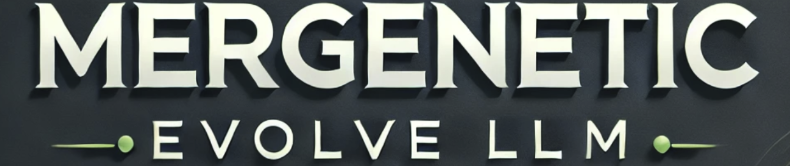

# 1. 🚀 Mergenetic Tutorial Notebook: Hello World! [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tommasomncttn/mergenetic/blob/main/notebooks/Introduction_to_Mergenetic.ipynb) 

Welcome to the `mergenetic` tutorial notebook! This guide introduces you to the `mergenetic` library, which frames model merging as a single- or multi-objective black-box optimization problem. By combining the powerful optimization capabilities of *pymoo* with the versatile merging strategies of *mergekit*, `mergenetic` enables **efficient evolutionary merging of LLMs on consumer-grade GPUs**.

---

### 📚 In this tutorial, you'll learn:

- ✅ How to install and set up the library.
- 🔧 An overview of the supported merging methods and evolutionary algorithms.
- 🧪 How to run an evolutionary merging experiment with a working example.


# 2. 🛠️ Installation and Imports

Before running the library, we need to install it.
Execute the following commands (or a shell cell) to set up the environment:


In [ ]:
# cell: setup mergenetic
import sys


def in_colab():
    try:
        import google.colab  # type: ignore

        return True
    except ImportError:
        return False


if in_colab():
    # — Colab setup —
    # clone via HTTPS to avoid SSH key errors

    # if mergenetic folder doesn't exist
    # then clone the repo
    #

    try:
        import mergenetic

        %cd mergenetic
    except ImportError:
        !git clone https://github.com/tommasomncttn/mergenetic.git
        %cd mergenetic
        # install dependencies & the editable package
        !git clone https://github.com/tommasomncttn/mergenetic.git
        %cd mergenetic
        # install dependencies & the editable package
        !UV_CONSTRAINT= UV_BUILD_CONSTRAINT= UV_PRERELEASE=if-necessary-or-explicit uv pip install -r requirements_nb.txt --system --quiet
        !UV_CONSTRAINT= UV_BUILD_CONSTRAINT= UV_PRERELEASE=if-necessary-or-explicit uv pip install -e . --system --quiet

## Fix to avoid having to restart the kernel

In [ ]:
if in_colab():
    import sys, importlib, pathlib

    # 0) make sure the real code exists
    real_pkg_dir = pathlib.Path("/content/mergenetic/src/mergenetic")
    if not real_pkg_dir.exists():
        raise RuntimeError("mergenetic/src/mergenetic not found – is the repo cloned?")

    # 1) purge every cached mergenetic module
    for name in list(sys.modules):
        if name == "mergenetic" or name.startswith("mergenetic."):
            del sys.modules[name]

    # 2) put src/ directory *first* on sys.path
    src_root = str(real_pkg_dir.parent)  # /content/mergenetic/src
    if src_root not in sys.path:
        sys.path.insert(0, src_root)

    # 3) also remove /content from sys.path if present
    for bad in ("", "/content"):
        if bad in sys.path:
            sys.path.remove(bad)

    # 4) reload
    importlib.invalidate_caches()
    import mergenetic, inspect, textwrap

    print("Now using:", inspect.getfile(mergenetic))
    print("Public names:", textwrap.shorten(", ".join(dir(mergenetic)), 100))

In [3]:
# Imports and Basic Setup

import numpy as np
import yaml
import os

# pymoo components
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM

# mergenetic imports
from mergenetic.searcher import Searcher
from mergenetic.merging import SlerpMerger
from mergenetic.utils import ConfigLmEval
from mergenetic.optimization.predefined_problems import (
    CrossLingualMathProblem,
    ConfigPE,
)
from mergenetic import PROJECT_ROOT

PROJECT_ROOT = PROJECT_ROOT / "notebooks"

# lm_eval
from lm_eval.tasks import TaskManager

# 3. 🧠 A Code-Free Overview of Mergenetic

### 3.1 ⚙️ Supported Merging Methods and Evolutionary Algorithms

`mergenetic` supports a range of merging methods via [`mergekit`](https://github.com/arcee-ai/mergekit), including:

- **Linear (Model Soups)**
- **SLERP**
- **Task Arithmetic**
- **TIES**
- **DARE** (can be combined with TIES or Task Arithmetic)

It also leverages powerful evolutionary algorithms from `pymoo`, such as:

- **Genetic Algorithm (GA)**
- **Differential Evolution (DE)**
- **NSGA-II**, **NSGA-III**, and more for multi-objective optimization

📖 For the complete list of supported algorithms and methods, check the [project README](https://github.com/tommasomncttn/mergenetic#readme).

---

💡 *New to model merging or evolutionary algorithms? No worries!*  
You don’t need to understand every detail to start using `mergenetic`. These two beginner-friendly blog posts are great starting points:

- 📚 [Model Merging (Hugging Face)](https://huggingface.co/blog/mlabonne/merge-models)
- 📚 [Intro to Evolutionary Algorithms](https://blog.evolv.ai/ai-101-intro-to-evolutionary-algorithms)

---

### 3.2 🧱 Submodules in the Library

The library is modular, and organized into several submodules:

- 🥣 **`merging`** – Model-weight merging logic (e.g., `LinearMerger`, `SlerpMerger`, `TiesDareMerger`)
- 📈 **`optimization`** – Defines the optimization problems (single or multi-objective)
- 🧬 **`searcher`** – Manages the evolutionary process and logs progress
- 📄 **`evaluation`** – Handles fitness evaluation during search
- 🪄 **`estimator`** – Smart estimators using **Item Response Theory** to cheaply approximate fitness (e.g., estimate GSM8K accuracy using 20 examples instead of 1300)
- 🧳 **`utils`** – Helper functions (e.g., GPU cleanup, model loading, batching)

This modular design makes it easy to **customize**, **extend**, and plug in your own logic where needed.

---

✅ Now you're ready to jump into the actual experiment!


# 3. Using Mergenetic To Do Cross-Lingual Transfer of Math Abilities

Now that we know how the library is structured, let's tackle a mock task: merging an Italian language model with a math model to transfer mathematical reasoning abilities across languages.

### Task Setup

In this example, we will:
- Use as **MATH MODEL**: [lmassaron/gemma-2-2b-it-grpo-gsm8k](https://huggingface.co/lmassaron/gemma-2-2b-it-grpo-gsm8k)
- Use as **ITALIAN MODEL**: [anakin87/gemma-2-2b-neogenesis-ita](https://huggingface.co/anakin87/gemma-2-2b-neogenesis-ita)
- Use the **SLERP** merger to combine the models' weights.
- Leverage a **GENETIC** algorithm for the evolutionary search.
- Define a fitness function using **LM-EVAL-HARNESS** to evaluate the merged model.

### How It Works

1. **Model Selection:**  
   The math model provides robust numerical reasoning, while the Italian model contributes language-specific expertise.

2. **Merging Strategy:**  
   The SLERP merger performs spherical interpolation between the two models' weights, balancing the strengths of each.

3. **Evolutionary Search:**  
   A Genetic algorithm is used to optimize the merging process by finding the best interpolation coefficients. This optimization is managed by `pymoo` via `mergenetic`.

4. **Fitness Evaluation:**  
   LM-EVAL-HARNESS defines a task that measures the mathematical accuracy of the merged model's outputs. This fitness function guides the evolutionary search towards optimal merges.

### Expected Outcome

The merged model should:
- Enhance math problem-solving abilities while maintaining strong Italian language fluency.
- Benefit from positive cross-lingual transfer of skills.
- Achieve a balance between numerical reasoning and language proficiency.

---

Ready to see this in action? Let's dive into the experiment and watch the evolution of cross-lingual transfer in model merging!


### 🧩 (Optional) Define a Configuration

Normally, you would define a configuration YAML file and load it using the `ConfigLmEval` class.  
However, in this tutorial we'll build the configuration inline for simplicity.

Still, here's an example of what a full configuration file might look like:

```yaml
# Required parameters
pop_size: 1                    # Population size
n_iter: 1                      # Number of evolutionary iterations
models:                        # Dictionary of models to merge
  ro: "meta-math/MetaMath-Mistral-7B"
base_model: "OpenLLM-Ro/RoMistral-7b-Instruct"
path_to_store_merged_model: "experiments/models/merged/"
path_to_store_config: "experiments/evolutionary-merging-lm-harness/"
dtype: "float16"
run_id: "romanian_math_gmpirt"
bench: "gsm8k"
mode: "gmpirt"
seed: 420

langs:
  - ro

tasks:
  search:
    ro: "gsm8k-ro"
    base: "gsm8k-ro"
  test:
    ro: "gsm8k-ro"

metric: "exact_match"

# Optional parameters
device: "cuda:2"
n_samples: 10
task_type: "FG_MATH"
eval_batch_size: 64
additional_templates_folder: "lm_tasks"
```

This configuration specifies everything needed to run an evolutionary merging experiment using LM-Eval-Harness, including:

- Population size and number of iterations
- Model references (math, base, etc.)
- Evaluation task and metric
- Device and data sampling options
- Output directories for logs and merged models

💡 You can modify any field above to fit your own experiment.


## 3.1 ⬇️ Download the Models

Before we begin, we'll need access to the Hugging Face Hub using an authentication token.

If you haven’t done this before, follow these steps:

1. Create a **read access token** here:  
   👉 [https://huggingface.co/settings/tokens](https://huggingface.co/settings/tokens)

2. Use the token in your code or environment to authenticate:


In [4]:
from huggingface_hub import notebook_login

notebook_login()

Now check that you logged in

In [5]:
from huggingface_hub import whoami

try:
    user_info = whoami()
    print("✅ Logged in as:", user_info["name"])
except Exception as e:
    print("❌ Not logged in:", str(e))

✅ Logged in as: crisostomi

We are ready to download the models

In [6]:
import os
from huggingface_hub import snapshot_download

# select the models
italian_model = "anakin87/gemma-2-2b-neogenesis-ita"
math_model = "lmassaron/gemma-2-2b-it-grpo-gsm8k"

model_dir = f"{PROJECT_ROOT}/model"
os.makedirs(model_dir, exist_ok=True)

In [7]:
snapshot_download(repo_id=math_model, local_dir=f"{model_dir}/{math_model}")

Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

'/media/donato/Extra-storage/Code/model-merging/mergenetic/notebooks/model/lmassaron/gemma-2-2b-it-grpo-gsm8k'

In [8]:
snapshot_download(
    repo_id=italian_model,
    local_dir=f"{model_dir}/{italian_model}",
)

Fetching 10 files:   0%|          | 0/10 [00:00<?, ?it/s]

'/media/donato/Extra-storage/Code/model-merging/mergenetic/notebooks/model/anakin87/gemma-2-2b-neogenesis-ita'

## 3.2 🧠 Fitness Definition for Evolutionary Merging: Task Setup & Subdataset Selection (Anchor Extraction)

Now we're ready to define the **task manager** that will drive our fitness evaluation.

In `mergenetic`, the fitness of a candidate merge can be computed using either:

- ✅ A built-in estimator class based on user-defined estiamtion methods (this allows to implement more creative fitness functions)
- 📊 Tasks from `lm-eval-harness` (the plug and play solutions)

In this tutorial, we’ll use **`lm-eval-harness`** to define a custom task for fitness computation.

#### 🚀 Create a New LM-Eval-Harness Task

The first step is to define a new `lm-eval-harness` task. You can skip this step if you're planning to use an existing task from the library.

You have **three options** depending on your use case:

1. **Brand New Task**  
   If it's a completely new task, follow the official guide:  
   👉 https://github.com/EleutherAI/lm-evaluation-harness/blob/main/docs/new_task_guide.md  
   Then place the resulting `.yaml` file in:
   ```
   mergenetic/lm_tasks/
   ```

2. **Existing Harness Task**  
   If the task already exists in `lm-eval-harness`, just copy the corresponding `.yaml` into:
   ```
   mergenetic/lm_tasks/
   ```

3. **Variation of a Mergenetic Task**  
   For a task similar to one already in `mergenetic` (e.g. a different language for `gsm8k`), duplicate the YAML of the closest task, modify it accordingly, and add it to:
   ```
   mergenetic/lm_tasks/
   ```

---

#### ✏️ Example: Creating `gsm8k-it` from `gsm8k-ro`

In this example, we'll go with option 3:  
We start from the Romanian version of GSM8K (`gsm8k-ro`) and adapt it to create the Italian version (`gsm8k-it`).


To do so, simply save this lm-eval-harness task inside the aforementioned repository:

````yaml
# Name of the evaluation task
task: gsm8k-it

# Hugging Face dataset location and name
dataset_path: openGPT-X/gsm8kx           # Points to the dataset repository
dataset_name: IT                         # Specifies the Italian split

# Output format expected from the model
output_type: generate_until              # Model generates text until a stopping string

# Data splits used during evaluation
test_split: test                         # Used for computing the metric (fitness)
fewshot_split: train                     # Used if few-shot examples are enabled
training_split: train                    # Optional, used by some few-shot or fine-tuning setups

# Prompt and expected answer format
doc_to_text: "Domanda: {{question}}\nRisposta:"   # Format input prompt
doc_to_target: "{{answer}}"                       # Format expected output

# Metrics used for scoring the model
metric_list:
  - metric: exact_match                  # Measures whether the output matches exactly
    aggregation: mean                    # Averages scores over all test samples
    higher_is_better: true
    ignore_case: true                    # Ignores case when comparing answers
    ignore_punctuation: false            # Punctuation must match
    regexes_to_ignore:                   # Regex patterns removed from both prediction and target before comparison
      - ","                              # Ignore commas
      - "\\$"                            # Ignore dollar signs
      - "(?s).*#### "                    # Remove everything before the answer marker
      - "\\.$"                           # Remove trailing period

# Generation configuration for the model
generation_kwargs:
  until:
    - "Întrebare:"                       # Stop when Romanian word for “Question” is generated (likely copy-paste relic)
    - "</s>"
    - "<|im_end|>"
  do_sample: false                       # No sampling — deterministic output
  temperature: 0.0                       # Greedy decoding

# Evaluation strategy
repeats: 1                               # Run each prompt once
num_fewshot: 0                           # Zero-shot evaluation

# Post-processing filters to extract answers from raw generations
filter_list:
  - name: "strict-match"
    filter:
      - function: "regex"               # Applies strict numeric pattern
        regex_pattern: "#### (\\-?[0-9\\.\\,]+)"
      - function: "take_first"          # Takes the first match only
  - name: "flexible-extract"
    filter:
      - function: "regex"               # More flexible pattern to capture different number formats
        group_select: -1
        regex_pattern: "(-?[$0-9.,]{2,})|(-?[0-9]+)"
      - function: "take_first"

# Optional metadata
metadata:
  version: 1.0

# Dataset loading configuration
dataset_kwargs:
  trust_remote_code: true               # Allows loading dataset with custom scripts (if required)
  `````



### 3.2.1 📁 Task Path Setup & Configuration Wrapper

We now define the path to the folder where LM-Eval-Harness tasks are stored and we insert the task file we outlined above.  
In the `mergenetic` repo, this is typically:

```python
TASKS_PATH = "mergenetic/lm_tasks"
```

If you're running this tutorial on **Google Colab**, everything is done automatically for you, simply run the next cells:

In [9]:
# INIT CONFIG OBJECT
config = ConfigLmEval()
config.additional_templates_folder = "lm_tasks"
config.bench = "gsm8k"

# STORING TASK PATH
storing_name_task = "gsm8k-it.yaml"
path_new_task = f"{PROJECT_ROOT}/../{config.additional_templates_folder}/{config.bench}/{storing_name_task}"


# DOWNLOAD THE YAML FILE IN THE STORING PATH
os.system(
    f"wget -O {path_new_task} https://gist.githubusercontent.com/tommasomncttn/0a8b8126ab809be0ed5a8020c6d790b2/raw/gsm8k-it.yaml"
)
print(f"gsm8k-it.yaml downloaded to {path_new_task}")

--2025-04-20 08:09:58--  https://gist.githubusercontent.com/tommasomncttn/0a8b8126ab809be0ed5a8020c6d790b2/raw/gsm8k-it.yaml
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 982 [text/plain]
Saving to: ‘/media/donato/Extra-storage/Code/model-merging/mergenetic/notebooks/../lm_tasks/gsm8k/gsm8k-it.yaml’

     0K                                                       100% 30,8M=0s

2025-04-20 08:09:58 (30,8 MB/s) - ‘/media/donato/Extra-storage/Code/model-merging/mergenetic/notebooks/../lm_tasks/gsm8k/gsm8k-it.yaml’ saved [982/982]



gsm8k-it.yaml downloaded to 
/media/donato/Extra-storage/Code/model-merging/mergenetic/notebooks/../lm_tasks/gsm8k/gsm8k-it.yaml

In [10]:
import os

os.system(
    f"wget -O {path_new_task} https://gist.githubusercontent.com/tommasomncttn/0a8b8126ab809be0ed5a8020c6d790b2/raw/gsm8k-it.yaml"
)

print(f"YAML file downloaded to {path_new_task}")

--2025-04-20 08:09:58--  https://gist.githubusercontent.com/tommasomncttn/0a8b8126ab809be0ed5a8020c6d790b2/raw/gsm8k-it.yaml
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 982 [text/plain]
Saving to: ‘/media/donato/Extra-storage/Code/model-merging/mergenetic/notebooks/../lm_tasks/gsm8k/gsm8k-it.yaml’

     0K                                                       100% 72,6M=0s

2025-04-20 08:09:58 (72,6 MB/s) - ‘/media/donato/Extra-storage/Code/model-merging/mergenetic/notebooks/../lm_tasks/gsm8k/gsm8k-it.yaml’ saved [982/982]



YAML file downloaded to 
/media/donato/Extra-storage/Code/model-merging/mergenetic/notebooks/../lm_tasks/gsm8k/gsm8k-it.yaml

### 3.2.2 📆 Initialize the Task Manager

Now we can initialize the **Task Manager**, which is responsible for managing evaluation during the evolutionary search.

It will:

- Load and validate the evaluation task(s) defined in your `lm-eval-harness` YAMLs
- Handle dataset loading and preprocessing
- Provide fitness scores to guide the search


In [11]:
# WHERE LM-EVAL-TASK CONFIGURATIONS ARE STORED
path_templates = f"{PROJECT_ROOT}/../{config.additional_templates_folder}"

# A UTILITY CLASS FOR WORKING WITH LM-EVAL-HARNESS TASKS
task_manager = TaskManager(include_path=path_templates)

# DEFINE THE LANGUAGE ID FOR CROSS-LINGUAL TRANSFER.
lang_id = "it"

# SPECIFY THE TASK NAME – MATCHES THE YAML FILE SAVED EARLIER IN `additional_templates_folder`.
task_name = "gsm8k-it"

# LOAD THE TASK FROM THE TASK MANAGER.
task = task_manager.load_task_or_group(task_name)[task_name]

print("Task setup complete.")

Repo card metadata block was not found. Setting CardData to empty.


Task setup complete.

#### Selection of Anchors

- One of the nicest feature of mergenetic is that it allows to simply select a subset of the dataset of our task to carry out the search.

- This is useful as a lot of time you do not want to estimate the ability of your LLMs on the full database, but only on a subset of it

- So what we will do is to select only a random subset of the data

- If you have any bias towards some anchors, simply save their index as `anchors`

- If you want to give more importance to some specific anchors in the computation of the fitness function simply modify the `anchors_weights`

In [12]:
# Randomly select anchors
config.n_samples = 10
num_test_samples = len(task.dataset["test"])
anchors = np.random.choice(range(num_test_samples), config.n_samples, replace=False)
anchors_weights = np.ones(len(anchors)) / len(anchors)

print("Anchor indices:", anchors)
print("Anchor weights:", anchors_weights)
print("Task setup complete.")

Anchor indices: [ 868  255 1309  435 1159  379 1234   78   51 1191]

Anchor weights: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]

Task setup complete.

### 3.3 🧾 Configuration Details for the Merging Run

Below we finalize our `ConfigLmEval` setup by specifying all necessary parameters:

- 🔢 **`config.seed`** – Sets the random seed to ensure reproducibility of the search process.  
  ```python
  config.seed = 42
  ```

- 🖥️ **`config.device`** – Specifies the device used for evaluation (e.g., `"cuda"` or `"cpu"`).  
  ```python
  config.device = "cuda"
  ```

- 🏷️ **`config.run_id`** – A unique identifier for the run, used to name logs, result files, and checkpoints.  
  ```python
  config.run_id = "demo_run"
  ```

- 🧪 **`config.tasks`** – Defines the evaluation tasks for both the **search** and the **test** phases.  
  Here, `"gsm8k-it"` is used for both, targeting Italian GSM8K.  
  ```python
  config.tasks = {
      "search": {"it": "gsm8k-it", "base": "gsm8k-it"},
      "test": {"it": "gsm8k-it"}
  }
  ```

- 🎯 **`config.metric`** – Determines the success metric used to judge whether a sample is correct.  
  We're using `"exact_match"` here, which is standard for GSM8K.  
  ```python
  config.metric = "exact_match"
  ```

- 📂 **`config.path_to_store_config`** – Where to save merging configurations and logs.  
  **`config.path_to_store_merged_model`** – Where to store the final merged models.  
  ```python
  config.path_to_store_config = str(PROJECT_ROOT) + "/experiments/evolutionary-merging-lm-harness/"
  config.path_to_store_merged_model = "/content/model/merged/"
  ```

- 🧠 **`config.models`** – A dictionary mapping language keys to model paths.  
  This is where you define which models will be merged.  
  ⚠️ *Note: the math model is listed here, not the Italian one for a Mergekit Compatibility Problem.*  
  ```python
  config.models = {"it": f"/content/model/{math_model}"}
  ```

- 🧱 **`config.base_model`** – The baseline model used as a reference or merging anchor.  
  For SLERP, you will pass instead the other method you want to merge. For more information check the Mergekit guide.  
  ```python
  config.base_model = f"/content/model/{italian_model}"
  ```

- 🧩 **`config.task_type`** – Indicates the type of task being run (e.g., `FG_MATH` for few-shot GSM8K).  
  ```python
  config.task_type = "FG_MATH"
  ```

- 🔍 **`config.mode`** – Specifies the estimator or evaluation strategy.  
  `"random"` here refer to using random subsampling of the dataset to speed up the fitness computation
  ```python
  config.mode = "random"
  ```

- 🌍 **`config.langs`** – List of language codes involved in the merging process.  
  In this case, we're targeting Italian:  
  ```python
  config.langs = ["it"]
  ```

- 📦 **`config.eval_batch_size`** – Batch size used during model evaluation.  
  Adjust based on available GPU memory.  
  ```python
  config.eval_batch_size = 8
  ```

---

✅ With all these values in place, your configuration object is now ready to be passed into the merging pipeline!


In [13]:
config.seed = 42
config.device = "cuda"
config.run_id = "demo_run"
config.tasks = {
    "search": {"it": "gsm8k-it", "base": "gsm8k-it"},
    "test": {"it": "gsm8k-it"},
}
config.metric = "exact_match"
config.path_to_store_config = (
    f"{PROJECT_ROOT}/../experiments/evolutionary-merging-lm-harness/"
)
config.path_to_store_merged_model = f"{model_dir}/merged/"
config.models = {"it": f"{model_dir}/{math_model}"}
config.base_model = f"{model_dir}/{italian_model}"
config.task_type = "FG_MATH"
config.mode = "mean"
config.langs = ["it"]
config.eval_batch_size = 8
config.additional_templates_folder = f"{PROJECT_ROOT}/../lm_tasks"
config

ConfigLmEval(pop_size=None, n_iter=None, path_to_store_config='/media/donato/Extra-storage/Code/model-merging/mergenetic/notebooks/../experiments/evolutionary-merging-lm-harness/', path_to_store_merged_model='/media/donato/Extra-storage/Code/model-merging/mergenetic/notebooks/model/merged/', datasets=None, run_id='demo_run', bench='gsm8k', models={'it': '/media/donato/Extra-storage/Code/model-merging/mergenetic/notebooks/model/lmassaron/gemma-2-2b-it-grpo-gsm8k'}, task_type='FG_MATH', langs=['it'], seed=42, n_samples=10, mode='mean', dtype='bfloat16', device='cuda', base_model='/media/donato/Extra-storage/Code/model-merging/mergenetic/notebooks/model/anakin87/gemma-2-2b-neogenesis-ita', force_evaluation=False, eval_batch_size=8, metric='exact_match', tasks={'search': {'it': 'gsm8k-it', 'base': 'gsm8k-it'}, 'test': {'it': 'gsm8k-it'}}, additional_templates_folder='/media/donato/Extra-storage/Code/model-merging/mergenetic/notebooks/../lm_tasks')

### 3.4 🎯 Set Estimation Parameters

Estimation parameters allow `mergenetic` to support **advanced evolutionary merging techniques**, such as fitness approximation using **Item Response Theory (IRT)**.  
In this tutorial, we will **skip the theoretical details** and focus on the minimal setup required to proceed.

You only need to configure the estimation block using information we already defined.

Here’s what you’ll specify:

- ⚖️ **Weights** – Used to compute a weighted average over multiple objectives (e.g., if you evaluate accuracy across several languages or metrics).  
  In this case, we’re using a single-task setup with uniform weighting.

- 📌 **Anchors** – Define which subset of the dataset (or samples) should be used during evaluation.  
  This lets you control the evaluation budget or simulate few-shot evaluations.

- 🧪 **Benchmark** – The dataset/task being used as the fitness benchmark.  
  For this tutorial, we’re using `gsm8k`.

- 🧠 **Estimator Type** – The kind of fitness estimator to use.  
  We're using a simple `sample_mean` approach (a.k.a. `"random"` in config), which averages correctness over sampled items.

- 📏 **Metric** – The evaluation metric extracted from LM-Eval-Harness output (e.g., `"exact_match"`).

---

Let’s now set these in the configuration and move on to launching the search!


In [14]:
est_parameters = ConfigPE(
    thetas=[None, None],
    weights=anchors_weights,
    sample_ids=anchors,
    bench=config.bench,
    mode=config.mode,
    correct_metric=config.metric,
)

print("Estimation parameters set.")
print("Mode:", config.mode)

Estimation parameters set.

Mode: mean

### 3.5 🧪 Define the Merger

Now it's time to initialize the **merger**, one of the core subroutines of `mergenetic`.

The merger is responsible for combining two models using a specified strategy (e.g., SLERP, TIES, DARE) based on the current candidate solution in the evolutionary search.  
It takes in model paths and a configuration, and outputs a merged model ready for evaluation.

In this tutorial, we’ll use the `SlerpMerger`, which performs spherical linear interpolation between model weights.  
You can easily swap in other merging strategies like `TiesMerger`, `TiesDareMerger`, or `LinearMerger` depending on your use case.

---

#### 🔧 Merger Initialization – Parameters Explained:

- **`run_id`**: Unique identifier for the run; used for saving intermediate files and YAMLs.
- **`path_to_base_model`**: Path to the *base model* (e.g., the Italian language model).
- **`path_to_model_1`**: Path to the *other model* (e.g., the math-enhanced model).
- **`path_to_store_yaml`**: Where to save the merger's YAML log/config (per run).
- **`path_to_store_merged_model`**: Output directory for the intermediate merged model.
- **`dtype`**: Precision used for model weights (typically `"float16"` or `"bfloat16"`).
- **`layer_range_base_model` / `layer_range_model_1`**: Define the range of layers to merge from each model (here: full model, 0–24).



In [15]:
from mergenetic.merging.taskarithmetic_merger import TaskArithmeticMerger


path_to_store_yaml = f"{config.path_to_store_config}/{config.run_id}/"

# merger = SlerpMerger(
#     run_id=config.run_id,
#     path_to_base_model=config.base_model,
#     path_to_model_1=config.models[lang_id],
#     path_to_store_yaml=path_to_store_yaml,
#     path_to_store_merged_model=config.path_to_store_merged_model,
#     dtype=config.dtype,
#     layer_range_base_model=[0, 18],
#     layer_range_model_1=[0, 18]
# )

merger = TaskArithmeticMerger(
    run_id=config.run_id,
    path_to_base_model=config.base_model,
    model_paths=[config.models[lang_id]],
    path_to_store_yaml=path_to_store_yaml,
    path_to_store_merged_model=config.path_to_store_merged_model,
    dtype=config.dtype,
)

print(
    f"Merger defined. Ready to combine {config.base_model} model with:",
    config.models[lang_id],
)

Merger defined. Ready to combine 
/media/donato/Extra-storage/Code/model-merging/mergenetic/notebooks/model/anakin87/gemma-2-2b-neogenesis-ita model 
with: /media/donato/Extra-storage/Code/model-merging/mergenetic/notebooks/model/lmassaron/gemma-2-2b-it-grpo-gsm8k

### 3.6 🧠 Define the Optimization Problem

To guide the evolutionary search towards the **best merged model**, we need to define a `MergingProblem`.  
This class tells the optimizer **how to evaluate each candidate merge**, using a fitness function (e.g., model accuracy on a task).

In `mergenetic`, you don’t need to implement this from scratch — several merging problems are already available.  
In this tutorial, we’ll use an example one: `CrossLingualMathProblem`.

> 🧩 `CrossLingualMathProblem` is designed to support merging scenarios where a language model is fused with a math-focused model, and the goal is to evaluate performance in a specific language (like Italian) on math tasks (like GSM8K).

---

#### 🔧 Parameters for `CrossLingualMathProblem`:

- **`merger`**: The merger object used to produce merged models.
- **`test_df` / `search_df`**: Optional datasets (must be `None` when using LM-Eval tasks).
- **`lm_eval_tasks`**: The task setup, as defined in your config (`config.tasks`).
- **`lang_id`**: Language we're targeting for evaluation (e.g., `"it"`).
- **`conf_pe`**: Estimation config (e.g., sampling strategy, anchors, metric).
- **`device`**: Evaluation device (`"cuda"` or `"cpu"`).
- **`n_var`**: Number of decision variables (e.g., number of interpolation weights).
- **`n_obj`**: Number of objectives — `1` for single-objective optimization (e.g., accuracy).
- **`n_eq_constr` / `n_ieq_constr`**: Number of equality and inequality constraints (set to `0` if unused).
- **`discrete`**: Whether to treat the search space as discrete (e.g., selecting from fixed layers/weights).
- **`eval_batch_size`**: Batch size for evaluation.
- **`additional_templates_folder`**: Where task templates are stored (e.g., `"lm_tasks"`).


In [16]:
device = config.device

problem = CrossLingualMathProblem(
    merger,
    test_df=None,
    search_df=None,
    lm_eval_tasks=config.tasks,
    lang_id=lang_id,
    conf_pe=est_parameters,
    device=device,
    n_var=11,  # Number of decision variables (merge coefficients, etc.)
    n_obj=1,  # Single-objective (accuracy)
    n_eq_constr=0,
    n_ieq_constr=0,
    discrete=True,
    eval_batch_size=config.eval_batch_size,
    additional_templates_folder=config.additional_templates_folder,
)

print(
    "Optimization problem created with single-objective for cross-lingual math tasks."
)

Optimization problem created with single-objective for cross-lingual math tasks.

### 3.7 🧬 Define the Evolutionary Algorithm

To optimize our merging problem, we now define an **evolutionary algorithm** using [`pymoo`](https://pymoo.org/).  
In this example, we’ll use a basic **Genetic Algorithm (GA)** with the following components:

- 🎲 **`IntegerRandomSampling`** – Initializes the population with random integers (suitable for discrete search spaces).
- 🔀 **`SBX` (Simulated Binary Crossover)** – Recombines parent solutions to explore the space.
- 🎯 **`PM` (Polynomial Mutation)** – Introduces diversity into the population via random mutations.
- 🧼 **Duplicate Elimination** – Prevents repeated individuals in the population.

This is a minimal setup, ideal for getting started.

---

#### ⚙️ Configuration Parameters:

- **`config.pop_size`** – Population size (number of candidate merges per generation).
- **`config.n_iter`** – Number of generations (iterations of the search loop).
- **`run_id`** – Used to tag logs, checkpoints, and outputs.

In [17]:
# INCREASE IF YOU ARE NOT SIMPLY TESTING THE LIBRARY, WE SUGGEST (2,2)->(25,10)
config.pop_size = 2
config.n_iter = 2
run_id = config.run_id
print("Population Size:", config.pop_size)
print("Number of Iterations:", config.n_iter)


algorithm = GA(
    pop_size=config.pop_size,
    sampling=IntegerRandomSampling(),
    crossover=SBX(),
    mutation=PM(),
    eliminate_duplicates=True,
)

print("Genetic Algorithm configured.")

Population Size: 2

Number of Iterations: 2

Genetic Algorithm configured.

### 3.8 🚀 Run the Search & Test the Results

Now that we’ve defined the merging problem and evolutionary algorithm, it’s time to **launch the search process** and evaluate the best merged model.

To do this, we use the `Searcher` class — the high-level orchestrator in `mergenetic`.

---

#### 🧠 What Is the `Searcher`?

The `Searcher` wraps everything needed to run an evolutionary merging experiment:

- 🧬 **`search()`**  
  Runs the optimization loop for `n_iter` iterations, evolving candidate merges and evaluating their fitness.

- 🧪 **`test()`**  
  Evaluates the **best merged model(s)** found during search on the designated test task(s). Saves performance metrics and logs.

- 📊 **`visualize_results()`** *(optional)*  
  Allows you to plot how fitness scores and model parameters evolved across generations (if available in `results_df`).

---

#### ⚙️ Instantiating the `Searcher`

To create a `Searcher`, you’ll need to pass the following parameters:

- **`problem`** (*MergingProblem*)  
  The optimization problem instance (e.g., `CrossLingualMathProblem`) that defines how to evaluate each merged model.

- **`algorithm`** (*pymoo Algorithm*)  
  The evolutionary algorithm you want to use — e.g., Genetic Algorithm, NSGA-II, etc.

- **`results_path`** (*str*)  
  Path to the folder where search results, intermediate files, and logs will be saved.

- **`n_iter`** (*int*)  
  Number of iterations (generations) to run the evolutionary algorithm.

- **`run_id`** (*str*)  
  A unique identifier for the experiment. Used to name result files and checkpoints.

- **`seed`** (*int*)  
  Random seed for reproducibility.

- **`verbose`** (*bool*, optional)  
  Whether to print live output during the optimization loop. Default is `True`.
---

#### ▶️ Step 1: Run the Evolutionary Search

```python
search_df = searcher.search()
```

This will:

- Evolve merge parameters for `n_iter` generations.
- Evaluate each candidate using the provided task.
- Save a CSV with all the results.

---

#### ✅ Step 2: Evaluate the Best Merge

```python
searcher.test()
```

This will:

- Use the best merge found during search.
- Run evaluation on the **test** task (`config.tasks["test"]`).
- Save the final results to a file (e.g., `run_id_test.csv` or `run_id_test_<task>.csv`).

---

#### 📈 (Optional) Step 3: Visualize the Results

```python
searcher.visualize_results()
```

If the merging problem logs results to a `results_df`, this method will generate line plots for:

- Fitness/objective scores over time
- Phenotypic parameters (like merge weights)

---

With this, you’ve completed a full evolutionary merging cycle!  
You now have a merged model tailored for **cross-lingual math performance in Italian**.


In [18]:
results_path = f"{config.path_to_store_config}/{run_id}/"

searcher = Searcher(
    problem=problem,
    algorithm=algorithm,
    results_path=results_path,
    n_iter=config.n_iter,
    run_id=config.run_id,
    seed=config.seed,
    verbose=False,
)

In [19]:
searcher.search()
print("Evolutionary search completed.")

Executing graph: 100%|██████████| 1442/1442 [00:26<00:00, 54.82it/s] 


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Repo card metadata block was not found. Setting CardData to empty.
Running generate_until requests:   0%|          | 0/10 [00:00<?, ?it/s]The 'max_batch_size' argument of HybridCache is deprecated and will be removed in v4.46. Use the more precisely named 'batch_size' argument instead.
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)
Running generate_until requests: 100%|██████████| 10/10 [00:41<00:00,  4.12s/it]
/media/donato/Extra-storage/Code/model-merging/mergenetic/src/mergenetic/optimization/merging_problem.py:158: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.results_df = pd.concat([self.results_df, pd.DataFrame([log_entry])], ignore_index=Tr

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Repo card metadata block was not found. Setting CardData to empty.
Executing graph: 100%|██████████| 1442/1442 [00:22<00:00, 63.20it/s] 


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Repo card metadata block was not found. Setting CardData to empty.
Executing graph: 100%|██████████| 1442/1442 [00:23<00:00, 62.58it/s] 


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Repo card metadata block was not found. Setting CardData to empty.
Running generate_until requests: 100%|██████████| 10/10 [00:42<00:00,  4.28s/it]


Evolutionary search completed.

In [20]:
config.additional_templates_folder

'/media/donato/Extra-storage/Code/model-merging/mergenetic/notebooks/../lm_tasks'

In [21]:
searcher.test()
print("Test of the final merged model is done.")
print("Results saved to:", results_path)

Executing graph: 100%|██████████| 1442/1442 [00:21<00:00, 67.49it/s] 


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Repo card metadata block was not found. Setting CardData to empty.
Running generate_until requests:   2%|▏         | 29/1309 [02:24<1:45:17,  4.94s/it]

KeyboardInterrupt: 

### 3.11. Conclusion

You have now:
1. Loaded a YAML configuration.
2. Set up a cross-lingual task with anchor-based performance estimation.
3. Defined a merger (SLERP).
4. Created an optimization problem for *pymoo*.
5. Configured a Genetic Algorithm.
6. Executed the evolutionary merging process and tested the final model.

Feel free to modify:
- The YAML config (e.g., different finetuned models or tasks).
- The merging method (TIES, DARE, Task Arithmetic, etc.).
- The evolutionary algorithm (DE, NSGA-II, etc.).

**Happy Merging!**

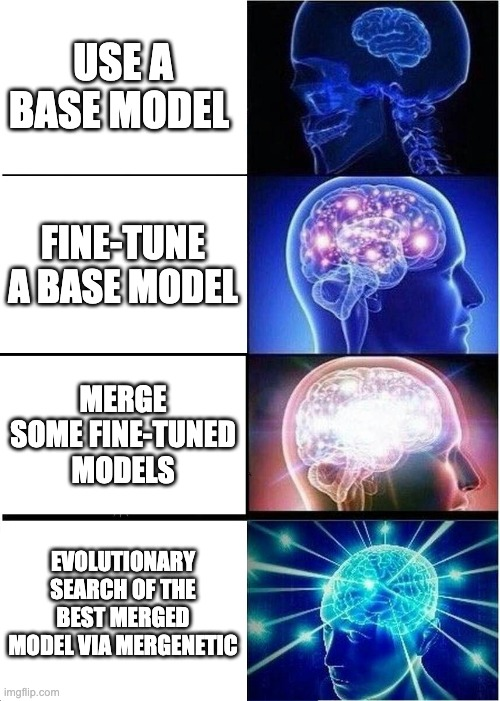